# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 20 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': 3,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
        
    },
    'lambda_net': {
        'epochs_lambda': 200,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'dropout': 0.25,
        'epochs': 100,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
        
        'seed_in_inet_training': False,
              
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': None, #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 0,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *


from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense[512, 1024]convNonelstmNoneoutput_6_drop0.25e100b512_customlnets_10000_30-200e64b_adam_train_1000_var_1_d_5_sparsity_3_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42
lnets_10000_30-200e64b_adam_train_1000_var_1_d_5_sparsity_3_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [8]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + path_identifier_lambda_net_data + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:  5.8min remaining: 26.0min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:  5.9min remaining:  4.9min
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:  6.0min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,0.000,0.000,-0.741,0.000,0.923,0.529,-0.492,1.824,-3.316,1.227,0.030,0.092,-1.053,2.260,-2.193,0.788,-0.009,-0.227,0.433,0.395,0.220,0.156,0.487,-0.297,0.390,0.147,0.575,-0.088,-0.019,0.488,0.145,0.514,0.012,0.258,0.313,0.281,0.016,0.040,0.008,-0.042,-0.404,-0.090,0.046,-0.291,-0.209,-0.233,0.000,0.000,-0.262,-0.298,0.231,0.231,-0.396,0.000,-0.334,0.278,-0.202,0.000,0.000,-0.335,0.239,-0.261,0.226,0.251,0.225,0.240,0.276,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.668,-0.870,0.351,0.403,-0.644,-0.408,-1.014,0.117,-0.400,-0.352,-0.364,-0.566,0.342,-0.512,0.662,0.226,0.366,0.258,0.313,-0.310,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.200
4684,1373158606,0.000,0.241,0.000,-0.188,-0.535,0.000,0.000,0.246,-0.054,0.023,-0.853,0.160,0.030,0.080,-1.035,2.222,-2.156,0.775,-0.009,-0.227,0.366,0.300,0.212,0.150,0.350,-0.297,0.283,0.432,0.478,-0.088,-0.019,0.369,0.147,0.441,0.012,0.261,0.299,0.278,0.053,0.258,0.282,-0.042,-0.404,-0.090,0.261,-0.291,-0.209,-0.233,0.000,0.000,-0.188,-0.209,0.000,0.000,-0.224,0.000,-0.212,-0.344,-0.123,0.000,0.000,-0.217,0.000,-0.181,0.001,-0.000,0.000,0.000,0.000,-0.229,-0.259,0.000,0.000,0.000,-0.219,0.000,0.000,0.000,-0.254,-0.359,-0.569,-0.730,0.194,0.222,-0.507,-0.408,-0.816,-0.450,-0.292,-0.352,-0.364,-0.462,0.156,-0.408,0.355,0.077,0.235,0.117,0.052,-0.978,-0.886,-0.261,-0.383,-0.059,-0.970,0.144,-0.258,-0.315,0.001
1731,1373158606,-0.739,0.000,0.000,0.786,0.773,0.000,-0.739,-0.032,0.534,-1.364,3.945,-1.543,-0.035,-0.348,0.487,-0.989,0.934,-0.331,-0.009,-0.227,0.098,-0.021,0.580,0.534,0.036,-0.297,-0.055,0.075,0.239,-0.088,-0.019,0.095,0.547,0.220,0.426,0.653,0.664,0.660,0.533,-0.109,-0.193,-0.042,-0.404,-0.090,-0.095,-0.291,-0.209,-0.233,0.000,0.000,0.157,0.165,-0.322,-0.377,0.167,0.000,0.167,0.184,0.148,0.000,0.000,0.160,-0.421,0.150,-0.369,-0.416,-0.199,-0.302,-0.440,0.169,0.217,0.000,0.000,0.000,0.167,0.000,0.000,0.000,-0.254,-0.359,-0.332,-0.424,0.852,1.003,-0.217,-0.408,-0.478,-0.069,-0.119,-0.352,-0.364,-0.191,0.974,-0.203,1.399,0.773,0.718,0.705,1.012,-0.559,-0.325,-0.261,-0.383,-0.059,-0.578,0.144,-0.258,-0.315,-0.153
4742,1373158606,0.173,-0.607,0.000,0.000,0.000,-0.939,0.167,-0.412,-1.588,4.875,-6.235,1.858,-0.031,-0.354,0.372,-0.759,0.728,-0.262,-0.009,-0.227,0.461,0.470,0.096,0.028,0.512,-0.297,0.461,0.601,0.595,-0.088,-0.019,0.390,0.031,0.573,0.007,0.221,0.180,0.183,0.033,0.426,0.475,-0.042,-0.404,-0.090,0.433,-0.291,-0.209,-0.233,0.000,0.000,-0.002,-0.311,0.099,0.100,-0.296,0.000,-0.338,-0.282,-0.002,0.000,0.000,-0.114,0.095,-0.002,-0.026,0.035,0.102,0.081,-0.048,-0.358,-0.412,0.000,0.000,0.000,-0.342,0.000,0.000,0.000,-0.254,-0.359,-0.471,-0.905,0.121,0.173,-0.644,-0.408,-1.014,-0.447,-0.335,-0.352,-0.364,-0.263,0.105,-0.412,0.392,-0.021,0.145,0.024,0.047,-1.166,-1.095,-0.261,-0.383,-0.059,-1.158,0.144,-0.258,-0.315,0.116
4521,1373158606,0.000,0.000,0.871,0.323,0.573,0.000,0.007,-0.228,2.480,-4.132,5.855,-2.241,0.030,0.087,-1.032,2.216,-2.151,0.773,-0.009,-0.227,0.124,0.082,0.587,0.521,0.158,-0.297,0.067,0.830,0.370,-0.088,-0.019,0.258,0.541,0.241,0.391,0.676,0.672,0.686,0.558,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.125

In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,-0.003,-0.001,0.004,0.007,-0.006,-0.004,-0.001,-0.012,0.046,-0.171,0.291,-0.156,0.005,-0.100,-0.422,0.923,-0.900,0.324,-0.009,-0.227,0.284,0.198,0.285,0.229,0.273,-0.297,0.173,0.443,0.427,-0.088,-0.019,0.312,0.232,0.392,0.105,0.367,0.367,0.363,0.177,0.130,0.085,-0.042,-0.404,-0.090,0.139,-0.291,-0.209,-0.233,0.000,0.000,-0.035,-0.058,-0.035,-0.049,-0.069,0.000,-0.064,-0.146,-0.014,0.000,0.000,-0.052,-0.066,-0.016,-0.043,-0.063,0.001,-0.025,-0.081,-0.066,-0.050,0.000,0.000,0.000,-0.063,0.000,0.000,0.000,-0.254,-0.359,-0.350,-0.415,0.332,0.398,-0.209,-0.408,-0.466,0.021,-0.161,-0.352,-0.364,-0.193,0.348,-0.255,0.656,0.187,0.327,0.219,0.335,-0.546,-0.281,-0.261,-0.383,-0.059,-0.561,0.144,-0.258,-0.315,0.002
std,0.000,0.407,0.406,0.409,0.407,0.405,0.408,0.387,0.439,1.098,3.244,4.547,1.844,0.030,0.210,0.704,1.494,1.446,0.520,0.000,0.000,0.117,0.124,0.131,0.136,0.130,0.000,0.127,0.217,0.111,0.000,0.000,0.125,0.143,0.108,0.141,0.150,0.126,0.129,0.187,0.132,0.174,0.000,0.000,0.000,0.129,0.000,0.000,0.000,0.000,0.000,0.119,0.136,0.139,0.151,0.153,0.000,0.140,0.271,0.106,0.000,0.000,0.141,0.170,0.105,0.150,0.177,0.098,0.131,0.202,0.145,0.173,0.000,0.000,0.000,0.140,0.000,0.000,0.000,0.000,0.000,0.162,0.224,0.192,0.228,0.254,0.000,0.251,0.352,0.171,0.000,0.000,0.233,0.248,0.142,0.345,0.262,0.138,0.190,0.337,0.303,0.355,0.000,0.000,0.000,0.285,0.000,0.000,0.000,0.093
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.999,-1.625,-5.736,-21.454,-26.346,-13.489,-0.036,-0.374,-1.112,-1.349,-2.343,-0.465,-0.009,-0.227,0.018,-0.096,-0.004,-0.077,-0.023,-0.297,-0.130,-0.105,0.188,-0.088,-0.019,0.041,-0.086,0.160,-0.208,0.041,0.097,0.067,-0.256,-0.179,-0.292,-0.042,-0.404,-0.090,-0.164,-0.291,-0.209,-0.233,0.000,0.000,-0.370,-0.465,-0.458,-0.475,-0.603,0.000,-0.467,-0.966,-0.628,0.000,0.000,-0.616,-0.530,-0.396,-0.501,-0.733,-0.458,-0.579,-0.589,-0.478,-0.698,0.000,0.000,0.000,-0.465,0.000,0.000,0.000,-0.254,-0.359,-0.940,-1.192,-0.024,0.087,-1.010,-0.408,-1.328,-1.196,-0.752,-0.352,-0.364,-0.898,0.013,-0.787,0.279,-1.378,-0.009,-1.026,-0.258,-1.794,-1.816,-0.261,-0.38

## Generate Datasets for Interpretation-Net training

In [13]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [14]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [15]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [16]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,0.000,0.000,0.000,0.430,0.914,-0.333,-0.280,2.388,-7.588,10.365,-3.619,-0.034,-0.297,0.560,-1.148,1.082,-0.382,-0.009,-0.227,0.131,0.016,0.524,0.501,0.093,-0.297,-0.020,0.508,0.274,-0.088,-0.019,0.144,0.520,0.247,0.409,0.577,0.563,0.569,0.515,-0.079,-0.141,-0.042,-0.404,-0.090,-0.065,-0.291,-0.209,-0.233,0.000,0.000,0.099,0.102,-0.361,-0.371,0.094,0.000,0.103,-0.136,0.091,0.000,0.000,0.093,-0.412,0.096,-0.346,-0.363,-0.244,-0.313,-0.428,0.106,0.144,0.000,0.000,0.000,0.105,0.000,0.000,0.000,-0.254,-0.359,-0.214,-0.265,0.924,1.045,-0.068,-0.408,-0.320,0.225,-0.050,-0.352,-0.364,-0.068,1.012,-0.131,1.479,0.749,0.693,0.714,1.088,-0.427,-0.247,-0.261,-0.383,-0.059,-0.437,0.144,-0.258,-0.315,-0.104
5985,1373158606,-0.496,0.000,0.252,0.645,0.000,0.000,-0.497,0.012,0.170,0.825,-0.137,0.025,-0.034,-0.329,0.503,-1.024,0.964,-0.340,-0.009,-0.227,0.114,-0.004,0.417,0.374,0.067,-0.297,-0.041,0.487,0.259,-0.088,-0.019,0.123,0.380,0.233,0.283,0.490,0.523,0.500,0.362,-0.098,-0.177,-0.042,-0.404,-0.090,-0.084,-0.291,-0.209,-0.233,0.000,0.000,0.128,0.133,-0.244,-0.251,0.126,0.000,0.135,-0.065,0.117,0.000,0.000,0.123,-0.285,0.123,-0.252,-0.244,-0.138,-0.200,-0.297,0.139,0.182,0.000,0.000,0.000,0.137,0.000,0.000,0.000,-0.254,-0.359,-0.244,-0.320,0.584,0.687,-0.109,-0.408,-0.382,0.165,-0.063,-0.352,-0.364,-0.098,0.658,-0.146,1.082,0.443,0.506,0.434,0.687,-0.489,-0.297,-0.261,-0.383,-0.059,-0.500,0.144,-0.258,-0.315,-0.132
6925,1373158606,-0.316,0.000,0.323,0.000,0.000,0.105,-0.315,-0.008,0.393,-0.203,0.236,0.007,-0.034,-0.290,0.585,-1.198,1.129,-0.398,-0.009,-0.227,0.176,0.067,0.327,0.284,0.133,-0.297,0.033,0.363,0.305,-0.088,-0.019,0.181,0.282,0.287,0.196,0.392,0.442,0.411,0.247,-0.021,-0.100,-0.042,-0.404,-0.090,-0.008,-0.291,-0.209,-0.233,0.000,0.000,0.092,0.094,-0.148,-0.170,0.088,0.000,0.095,-0.000,0.086,0.000,0.000,0.088,-0.201,0.090,-0.173,-0.122,-0.007,-0.065,-0.200,0.098,0.115,0.000,0.000,0.000,0.097,0.000,0.000,0.000,-0.254,-0.359,-0.238,-0.270,0.385,0.508,-0.087,-0.408,-0.315,0.073,-0.085,-0.352,-0.364,-0.094,0.510,-0.164,0.964,0.248,0.376,0.255,0.552,-0.403,-0.199,-0.261,-0.383,-0.059,-0.418,0.144,-0.258,-0.315,-0.096
9619,1373158606,0.123,0.000,0.000,-0.940,0.676,0.000,0.123,-0.030,0.341,-2.246,2.613,-0.961,0.030,0.078,-1.017,2.186,-2.123,0.764,-0.009,-0.227,0.292,0.203,0.206,0.143,0.261,-0.297,0.171,0.321,0.439,-0.088,-0.019,0.292,0.140,0.424,0.002,0.255,0.292,0.271,0.045,0.122,0.083,-0.042,-0.404,-0.090,0.133,-0.291,-0.209,-0.233,0.000,0.000,-0.026,-0.065,0.048,0.048,-0.068,0.000,-0.066,-0.075,0.000,0.000,0.000,-0.058,0.048,0.000,0.049,0.046,0.048,0.047,0.047,-0.061,-0.036,0.000,0.000,0.000,-0.061,0.000,0.000,0.000,-0.254,-0.359,-0.296,-0.325,0.196,0.227,-0.166,-0.408,-0.352,-0.049,-0.191,-0.352,-0.364,-0.163,0.162,-0.268,0.427,0.078,0.235,0.117,0.074,-0.401,-0.138,-0.261,-0.383,-0.059,-0.424,0.144,-0.258,-0.315,0.049
6916,1373158606,-0.533,0.000,0.000,-0.708,0.000,-0.974,-0.433,-0.869,2.547,-2.252,-4.521,3.953,-0.036,-0.374,0.464,-0.961,0.927,-0.335,-0.009,-0.227,0.282,0.175,0.254,0.079,0.241,-0.297,0.142,0.321,0.410,-0.088,-0.019,0.288,0.078,0.392,0.008,1.240,0.346,0.328,0.034,0.089,0.028,-0.042,-0.404,-0.090,0.101,-0.291,-0.209,-0.233,0.000,0.000

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.000,0.977,-0.064,0.000,0.000,0.272,0.410,0.007,-0.582,3.109,-2.032,0.030,0.091,-1.053,2.259,-2.192,0.788,-0.009,-0.227,0.122,0.082,0.283,0.219,0.105,-0.297,0.066,0.994,0.349,-0.088,-0.019,0.557,0.218,0.353,0.075,0.339,0.368,0.352,0.133,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.122,-0.084,0.086,0.086,-0.106,0.000,-0.069,-0.556,-0.001,0.000,0.000,-0.158,0.086,-0.001,0.087,0.084,0.086,0.085,0.085,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.183,-0.225,0.278,0.310,-0.025,-0.408,-0.258,0.727,-0.082,-0.352,-0.364,0.517,0.244,-0.183,0.494,0.158,0.315,0.197,0.152,-0.310,-0.045,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.087
5392,1373158606,0.502,-0.666,-0.803,0.000,0.000,0.000,0.500,-0.594,-1.292,1.261,-1.397,0.557,0.025,-0.136,-0.673,1.487,-1.470,0.535,-0.009,-0.227,0.471,0.348,0.079,0.006,0.447,-0.297,0.329,0.554,0.615,-0.088,-0.019,0.485,0.003,0.592,-0.156,0.178,0.169,0.169,-0.138,0.269,0.282,-0.042,-0.404,-0.090,0.284,-0.291,-0.209,-0.233,0.000,0.000,-0.032,-0.183,0.166,0.175,-0.135,0.000,-0.135,-0.118,-0.001,0.000,0.000,-0.033,0.174,-0.001,0.191,0.100,0.164,0.143,0.208,-0.205,-0.245,0.000,0.000,0.000,-0.182,0.000,0.000,0.000,-0.254,-0.359,-0.478,-0.542,0.175,0.259,-0.366,-0.408,-0.557,-0.250,-0.348,-0.352,-0.364,-0.336,0.194,-0.425,0.642,0.008,0.177,0.056,0.237,-0.692,-0.568,-0.261,-0.383,-0.059,-0.679,0.144,-0.258,-0.315,0.178
4718,1373158606,0.000,0.568,0.000,0.000,0.177,-0.243,-0.001,0.613,-0.360,1.076,-1.162,0.341,0.030,0.092,-1.053,2.259,-2.191,0.788,-0.009,-0.227,0.246,0.221,0.327,0.264,0.251,-0.297,0.066,0.370,0.332,-0.088,-0.019,0.212,0.262,0.315,0.121,0.380,0.412,0.395,0.176,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.163,-0.185,0.000,0.000,-0.196,0.000,-0.069,-0.078,-0.028,0.000,0.000,-0.046,0.000,-0.012,0.000,-0.010,0.000,0.000,-0.013,-0.048,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.366,-0.540,0.300,0.328,-0.278,-0.408,-0.257,0.064,-0.072,-0.352,-0.364,-0.068,0.262,-0.149,0.484,0.183,0.341,0.224,0.161,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.000
990,1373158606,-0.178,0.000,-0.961,0.759,0.000,0.000,-0.141,-0.503,1.192,-3.394,3.787,-1.335,-0.036,-0.374,0.464,-0.962,0.928,-0.335,-0.009,-0.227,0.301,0.195,0.219,0.157,0.255,-0.297,0.162,0.311,0.423,-0.088,-0.019,0.302,0.153,0.409,0.009,0.265,0.305,0.283,0.373,0.110,0.046,-0.042,-0.404,-0.090,0.122,-0.291,-0.209,-0.233,0.000,0.000,0.041,0.041,0.001,0.001,0.040,0.000,0.041,0.036,0.040,0.000,0.000,0.040,0.001,0.040,-0.023,0.000,0.001,0.000,-0.275,0.041,0.039,0.000,0.000,0.000,0.041,0.000,0.000,0.000,-0.254,-0.359,-0.313,-0.306,0.198,0.225,-0.152,-0.408,-0.329,-0.041,-0.180,-0.352,-0.364,-0.171,0.158,-0.257,0.393,0.082,0.240,0.122,0.996,-0.367,-0.087,-0.261,-0.383,-0.059,-0.395,0.144,-0.258,-0.315,-0.041
6498,1373158606,0.861,0.000,0.000,0.460,0.000,-0.056,0.780,0.349,-0.000,0.000,-0.000,0.000,0.030,0.091,-1.053,2.259,-2.192,0.788,-0.009,-0.227,0.282,0.083,0.282,0.219,0.249,-0.297,0.067,0.287,0.396,-0.088,-0.019,0.287,0.214,0.380,0.076,0.330,0.369,0.347,0.116,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,0.000,-0.083,0.203,

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.000,0.981,0.000,0.000,-0.831,0.641,0.873,-2.449,6.925,-7.655,2.656,0.030,0.092,-1.052,2.258,-2.190,0.787,-0.009,-0.227,0.227,0.151,0.316,0.253,0.466,-0.297,0.413,0.325,0.356,-0.088,-0.019,0.236,0.250,0.341,0.111,0.366,0.403,0.382,0.157,0.040,0.008,-0.042,-0.404,-0.090,0.046,-0.291,-0.209,-0.233,0.000,0.000,0.004,0.006,0.171,0.170,-0.346,0.000,-0.306,0.171,0.004,0.000,0.000,0.004,0.175,0.004,0.166,0.183,0.168,0.177,0.193,-0.047,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.222,-0.251,0.351,0.389,-0.656,-0.408,-1.189,0.099,-0.102,-0.352,-0.364,-0.089,0.325,-0.179,0.594,0.230,0.382,0.267,0.251,-0.309,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.153
8291,1373158606,0.000,0.402,-0.761,0.000,-0.451,0.000,0.009,0.256,-0.074,-1.314,0.634,-0.312,0.029,-0.045,-1.044,2.261,-2.207,0.796,-0.009,-0.227,0.412,0.333,0.200,0.137,0.384,-0.297,0.319,0.460,0.557,-0.088,-0.019,0.415,0.135,0.511,0.019,0.260,0.286,0.270,0.043,0.296,0.308,-0.042,-0.404,-0.090,0.301,-0.291,-0.209,-0.233,0.000,0.000,-0.173,-0.229,0.002,0.002,-0.240,0.000,-0.238,-0.261,-0.112,0.000,0.000,-0.209,0.002,-0.159,0.017,0.000,0.002,0.002,-0.000,-0.255,-0.278,0.000,0.000,0.000,-0.242,0.000,0.000,0.000,-0.254,-0.359,-0.588,-0.765,0.179,0.208,-0.556,-0.408,-0.841,-0.410,-0.375,-0.352,-0.364,-0.493,0.142,-0.457,0.365,0.061,0.219,0.101,0.034,-0.968,-0.825,-0.261,-0.383,-0.059,-0.966,0.144,-0.258,-0.315,0.002
4607,1373158606,0.000,0.000,-0.766,-0.485,0.000,-0.896,-0.011,0.368,-3.729,8.520,-11.455,4.235,-0.031,-0.353,0.371,-0.757,0.725,-0.261,-0.009,-0.227,0.593,0.524,0.069,0.079,0.609,-0.297,0.497,0.744,0.717,-0.088,-0.019,0.631,0.079,0.691,0.008,0.384,0.141,0.289,0.034,0.459,0.524,-0.042,-0.404,-0.090,0.465,-0.291,-0.209,-0.233,0.000,0.000,-0.253,-0.368,-0.011,-0.086,-0.394,0.000,-0.373,-0.438,-0.224,0.000,0.000,-0.329,-0.085,-0.107,-0.025,-0.009,-0.022,-0.011,-0.044,-0.383,-0.446,0.000,0.000,0.000,-0.368,0.000,0.000,0.000,-0.254,-0.359,-0.750,-0.953,0.025,0.176,-0.750,-0.408,-1.025,-0.609,-0.533,-0.352,-0.364,-0.674,0.111,-0.547,0.393,-0.181,0.044,-0.119,0.048,-1.152,-1.061,-0.261,-0.383,-0.059,-1.151,0.144,-0.258,-0.315,-0.001
5114,1373158606,-0.373,0.000,0.872,0.000,-0.963,0.000,-0.377,0.176,0.444,-0.987,0.979,-0.357,-0.035,-0.367,0.448,-0.921,0.881,-0.316,-0.009,-0.227,0.230,0.123,0.307,0.246,0.187,-0.297,0.089,0.269,0.356,-0.088,-0.019,0.234,0.244,0.339,0.103,0.363,0.391,0.375,0.164,0.035,-0.052,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,0.101,0.103,-0.004,-0.000,0.098,0.000,0.104,0.036,0.096,0.000,0.000,0.097,-0.000,0.099,-0.005,-0.005,-0.016,-0.005,-0.000,0.107,0.143,0.000,0.000,0.000,0.106,0.000,0.000,0.000,-0.254,-0.359,-0.276,-0.289,0.290,0.322,-0.121,-0.408,-0.324,0.004,-0.132,-0.352,-0.364,-0.133,0.256,-0.210,0.523,0.171,0.328,0.210,0.171,-0.394,-0.213,-0.261,-0.383,-0.059,-0.412,0.144,-0.258,-0.315,-0.105
1859,1373158606,0.664,0.000,0.000,-0.641,0.000,0.344,0.664,-0.037,0.380,-1.967,1.837,-0.524,0.030,0.091,-1.053,2.258,-2.191,0.788,-0.009,-0.227,0.302,0.210,0.191,0.126,0.258,-0.297,0.189,0.141,0.470,-0.088,-0.019,0.324,0.118,0.417,-0.019,0.231,0.282,0.253,-0.011,0.198,0.008,-0.042,-0.404,-0.090,0.201,-0.291,-0.209,-0.233,0.000,0.000,-

## Interpretation Network Training

[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed: 15.0min
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed: 16.5min remaining: 74.3min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed: 16.9min remaining: 29.6min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed: 17.0min remaining: 14.2min
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed: 17.1min remaining:  6.4min
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed: 17.5min finished


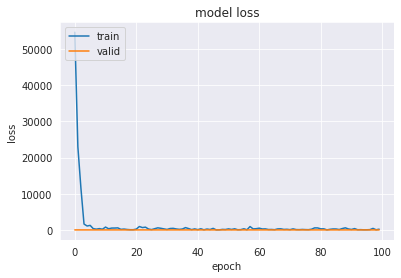

In [20]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [21]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [22]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [23]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.208,0.294,6.011,0.266,0.000,0.019,0.026,0.449,-0.070,0.208,0.570,0.023,-0.005,-0.005,0.543,0.554
inetPoly_VS_targetPoly_test,0.213,0.301,5.561,0.269,0.002,0.019,0.025,2.367,0.140,0.197,0.566,0.023,-0.034,-0.034,0.537,0.548
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.011,0.014,0.431,0.953,0.095,0.191,0.012,-0.005,-0.005,0.543,0.546
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.012,0.015,0.703,0.960,0.095,0.198,0.012,-0.034,-0.033,0.537,0.541
inetPoly_VS_lstsqTarget_valid,0.854,1.128,41.930,0.120,0.000,0.348,0.405,2.177,-421.395,4.069,3.364,0.196,-0.005,-0.082,0.543,0.092
inetPoly_VS_lstsqTarget_test,0.837,1.111,93.370,0.116,0.000,0.341,0.397,4.411,-123.327,3.214,2.789,0.195,-0.034,-0.083,0.537,0.092
inetPoly_VS_lstsqLambda_valid,1.095,2.454,25.866,0.271,0.026,0.011,0.014,0.432,0.953,0.094,0.184,0.012,-0.005,-0.005,0.543,0.546
inetPoly_VS_lstsqLambda_test,1.095,2.503,40.806,0.264,0.017,0.012,0.015,0.703,0.960,0.095,0.191,0.012,-0.034,-0.033,0.537,0.541
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.002,0.002,0.044,1.000,0.009,0.041,0.002,-0.005,-0.005,0.546,0.546
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.002,0.002,0.049,1.000,0.009,0.040,0.002,-0.033,-0.033,0.541,0.541


In [24]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.040,0.013,0.005,0.014,0.036,0.006,0.006,0.014,0.009,0.008,0.071,0.008,0.017,0.004,0.015,0.077,0.006,0.007,0.018,0.006,0.003,0.003,0.007,0.010,0.012,0.016,0.015,0.006,0.029,0.009,0.010,0.007,0.004,0.008,0.054,0.003,0.007,0.007,0.016,0.003,0.061,0.009,0.013,0.022,0.007,0.022,0.006,0.026,0.016,0.011,0.085,0.015,0.008,0.005,0.010,0.019,0.009,0.010,0.020,0.016,0.106,0.011,0.007,0.014,0.003,0.011,0.009,0.012,0.020,0.013,0.029,0.017,0.011,0.041,0.005,0.079,0.011,0.006,0.003,0.006,0.010,0.008,0.006,0.006,0.012,0.015,0.008,0.005,0.060,0.017,0.011,0.044,0.036,0.010,0.021,0.028,0.023,0.022,0.017,0.021,0.016,0.014,0.013,0.033,0.006,0.007,0.007,0.002,0.005,0.009,0.008,0.007,0.015,0.010,0.018,0.005,0.059,0.006,0.009,0.007,0.025,0.009,0.004,0.010,0.120,0.021,0.020,0.012,0.003,0.007,0.014,0.020,0.007,0.104,0.012,0.015,0.005,0.008,0.009,0.009,0.006,0.024,0.021,0.041,0.006,0.007,0.008,0.011,0.053,0.008,0.009,0.013,0.031,0.009,0.007,0.043,0.127,0.015,0.005,0.029,0.008,0.002,0.002,0.004,0.016,0.010,0.009,0.013,0.024,0.007,0.036,0.009,0.006,0.010,0.002,0.103,0.011,0.008,0.013,0.

In [25]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.963,0.999,0.998,0.959,0.789,0.999,0.999,0.996,0.985,0.995,0.069,0.999,0.932,0.999,0.993,0.896,0.997,0.995,0.929,0.989,1.000,1.000,0.997,0.993,0.997,0.995,0.995,0.995,0.995,0.998,0.997,0.994,0.999,0.998,0.657,1.000,0.991,0.999,0.983,1.000,0.350,0.999,0.981,0.848,0.999,0.924,0.994,0.996,0.991,0.998,-0.536,0.988,0.994,0.974,0.998,0.978,0.994,0.998,0.996,0.876,-0.055,0.996,0.998,0.979,0.999,0.999,0.997,0.995,0.948,0.994,0.542,0.972,0.979,0.974,-0.590,0.556,0.993,1.000,0.994,0.999,0.999,0.998,0.955,1.000,0.998,0.998,0.989,0.969,0.200,0.988,0.908,0.866,0.968,0.987,0.994,0.825,0.996,0.997,0.995,0.994,0.997,0.996,0.992,0.650,0.990,0.999,0.576,1.000,0.999,0.992,0.962,0.987,0.815,0.999,0.996,0.990,0.520,1.000,0.988,0.983,0.789,0.991,0.959,0.978,0.529,0.996,0.994,0.997,0.998,0.999,0.992,0.998,0.998,0.544,0.967,0.998,1.000,0.973,0.990,0.996,0.995,0.898,0.988,-144.745,0.998,0.998,0.989,0.995,0.763,0.999,0.671,0.995,0.941,0.994,0.999,0.231,-0.104,0.897,0.997,0.728,0.999,1.000,0.995,1.000,0.929,0.994,0.997,0.995,0.982,0.999,0.985,0.961,0.997,0.992,1.000,0.715,0.997,0.999,0

In [26]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-47.41184977907007


<IPython.core.display.Math object>

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda)

-83.37171757812175


<IPython.core.display.Math object>

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [29]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.931262359174345


<IPython.core.display.Math object>

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

0.9683376888721854


<IPython.core.display.Math object>

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [32]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.13991162581826566 (1000 Samples)
Mean (only positive): 0.9495992627175239 (943 Samples)


In [33]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.2897885629178508 (1000 Samples)
Mean (only positive): 0.9656964532070053 (953 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

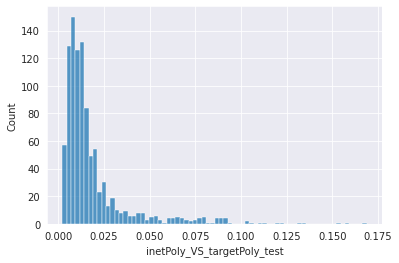

In [34]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

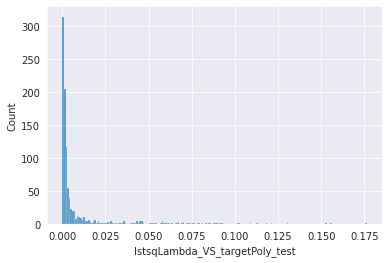

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'])


[(-30.0, 1.0)]

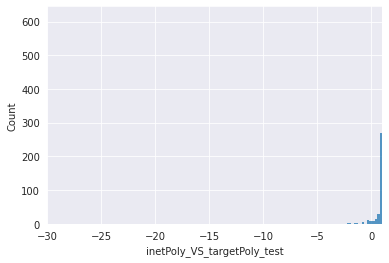

In [36]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

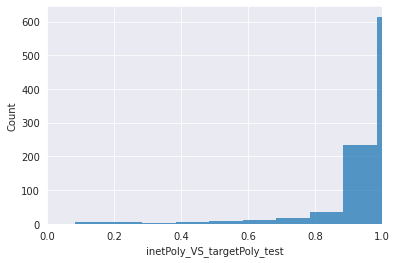

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

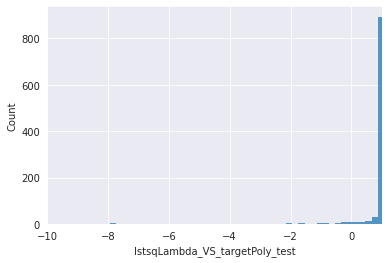

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

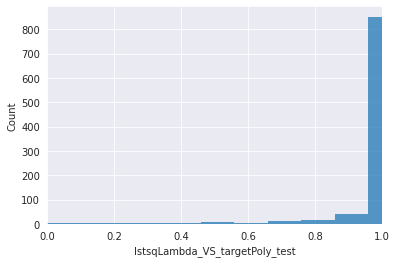

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

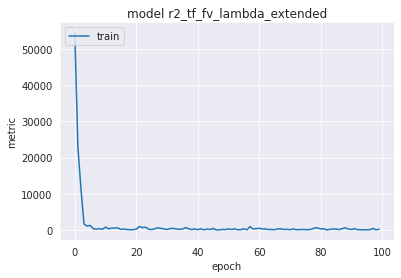

In [40]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


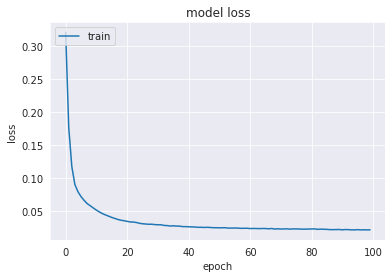

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

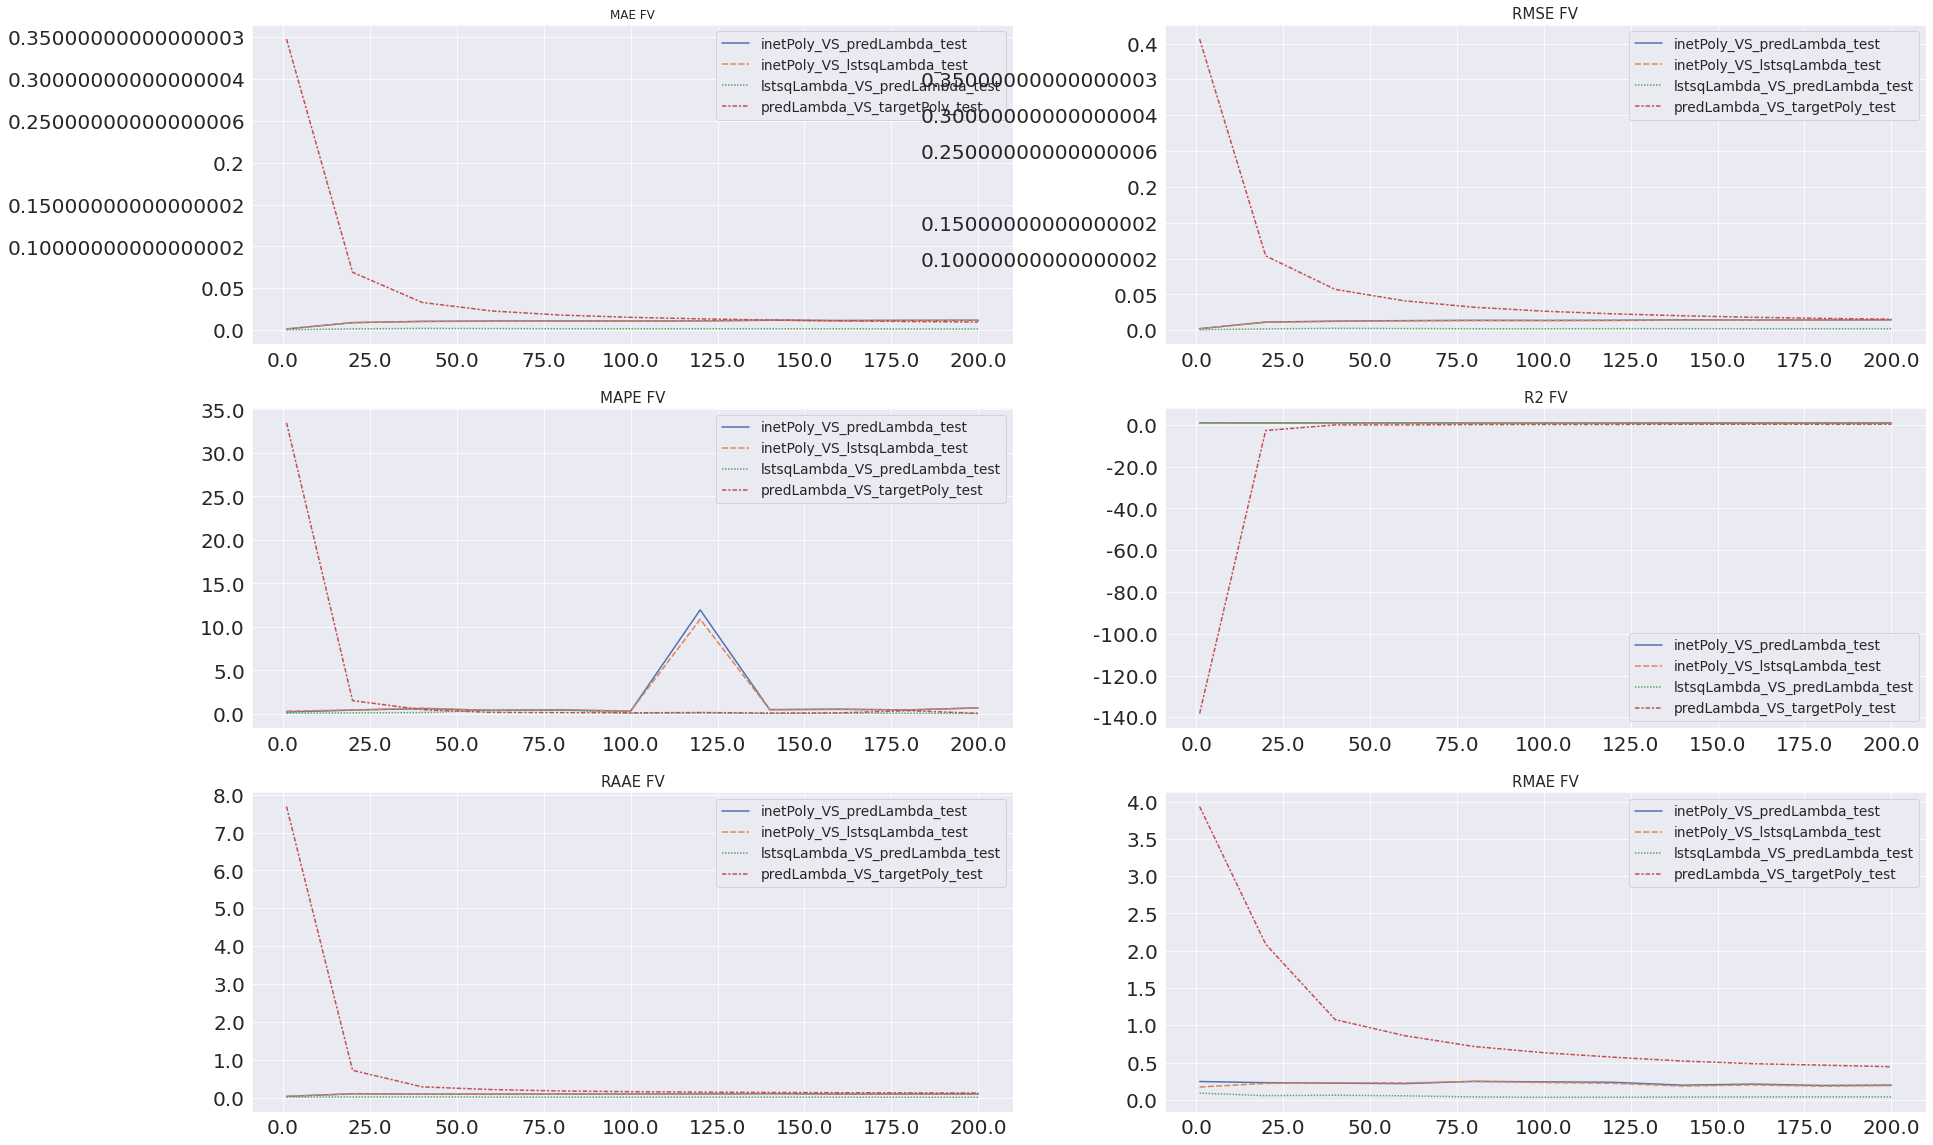

In [42]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

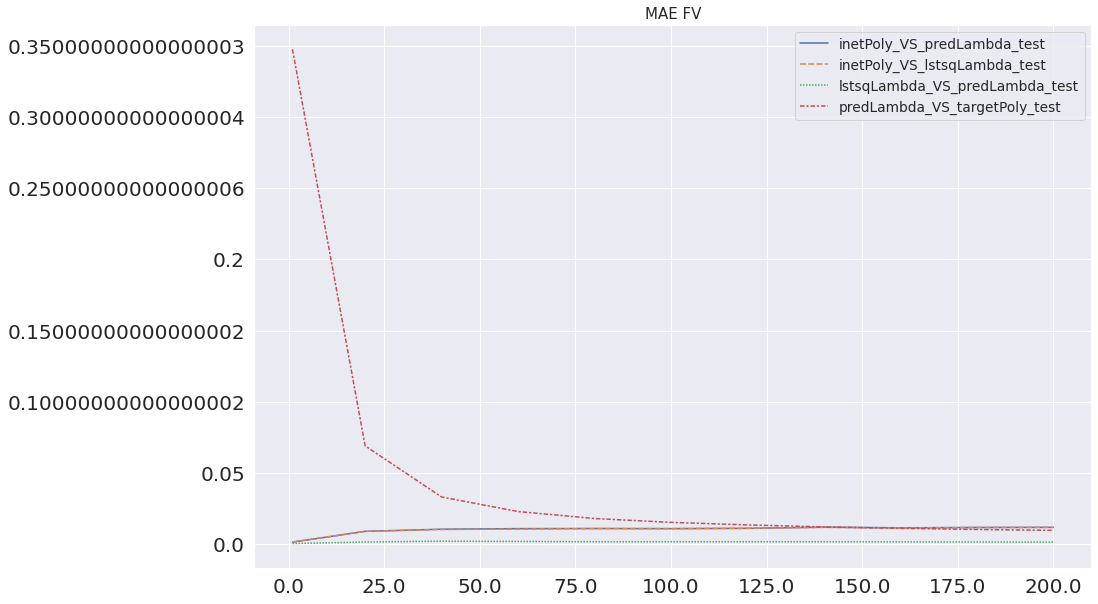

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

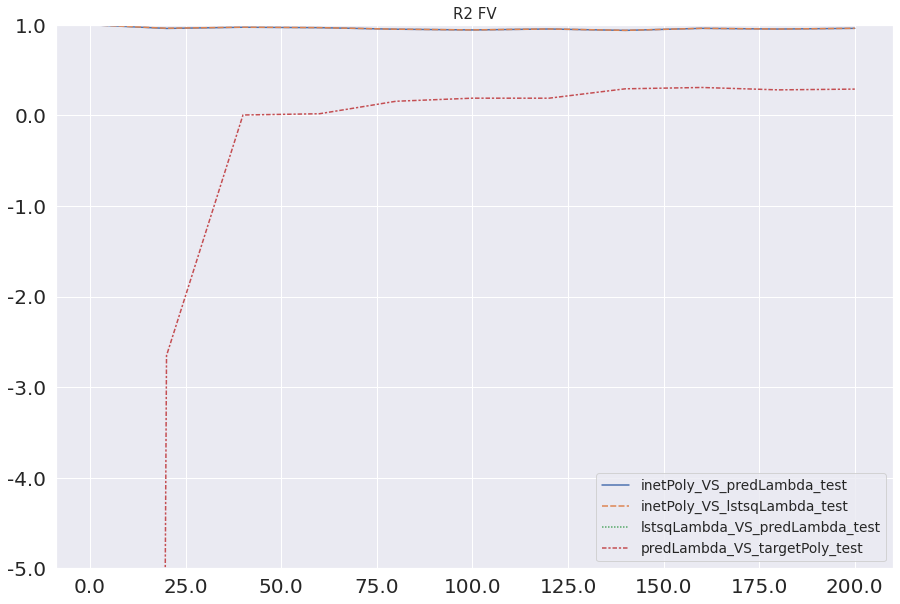

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [45]:
len(inet_preds_test_list)

11

In [46]:
len(lambda_net_test_dataset.target_polynomial_list)

1000

In [47]:
index = 3

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print_polynomial_from_coefficients(polynomial_target)
print_polynomial_from_coefficients(polynomial_lstsq_target)
print_polynomial_from_coefficients(polynomial_lstsq_lambda)
print_polynomial_from_coefficients(polynomial_inet)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

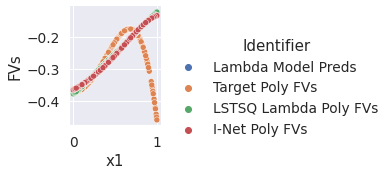

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=1)

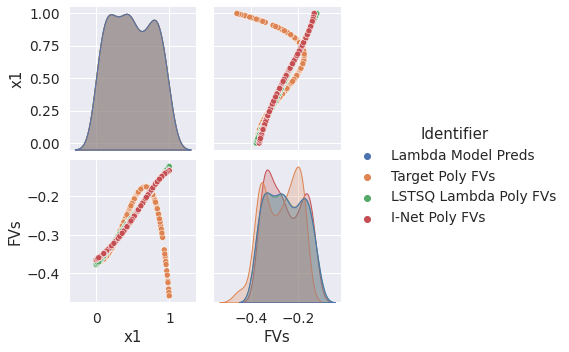

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=2)

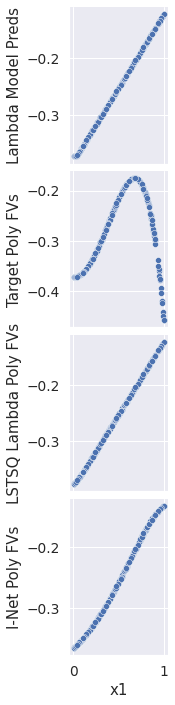

In [50]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [51]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [52]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [53]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0263


In [54]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3416


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [55]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [56]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.3998


In [57]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [58]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()